# XGBoost running with only VVR_1 and VVR_2

In [1]:
import pandas as pd
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 

# Import data 

In [2]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_train_smote_12-06-2024.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_train_smote_12-06-2024.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/X_test_12-06-2024.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/y_test_12-06-2024.csv')

In [3]:
# Drop unnamed columns 
X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

In [4]:
columns_to_drop = ['Condition', 'Sum_456', 'AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation', 'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square', 'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation', 'AU02_r__maximum', 'AU02_r__mean', 'AU02_r__root_mean_square', 'AU04_r__sum_values', 'AU04_r__variance', 'AU04_r__standard_deviation', 'AU04_r__maximum', 'AU04_r__mean', 'AU04_r__root_mean_square', 'AU05_r__sum_values', 'AU05_r__variance', 'AU05_r__standard_deviation', 'AU05_r__maximum', 'AU05_r__mean', 'AU05_r__root_mean_square', 'AU06_r__sum_values', 'AU06_r__variance', 'AU06_r__standard_deviation', 'AU06_r__maximum', 'AU06_r__mean', 'AU06_r__root_mean_square', 'AU07_r__sum_values', 'AU07_r__variance', 'AU07_r__standard_deviation', 'AU07_r__maximum', 'AU07_r__mean', 'AU07_r__root_mean_square', 'AU09_r__sum_values', 'AU09_r__variance', 'AU09_r__standard_deviation', 'AU09_r__maximum', 'AU09_r__mean', 'AU09_r__root_mean_square', 'AU10_r__sum_values', 'AU10_r__variance', 'AU10_r__standard_deviation', 'AU10_r__maximum', 'AU10_r__mean', 'AU10_r__root_mean_square', 'AU12_r__sum_values', 'AU12_r__variance', 'AU12_r__standard_deviation', 'AU12_r__maximum', 'AU12_r__mean', 'AU12_r__root_mean_square', 'AU14_r__sum_values', 'AU14_r__variance', 'AU14_r__standard_deviation', 'AU14_r__maximum', 'AU14_r__mean', 'AU14_r__root_mean_square', 'AU15_r__sum_values', 'AU15_r__variance', 'AU15_r__standard_deviation', 'AU15_r__maximum', 'AU15_r__mean', 'AU15_r__root_mean_square', 'AU17_r__sum_values', 'AU17_r__variance', 'AU17_r__standard_deviation', 'AU17_r__maximum', 'AU17_r__mean', 'AU17_r__root_mean_square', 'AU20_r__sum_values', 'AU20_r__variance', 'AU20_r__standard_deviation', 'AU20_r__maximum', 'AU20_r__mean', 'AU20_r__root_mean_square', 'AU23_r__sum_values', 'AU23_r__variance', 'AU23_r__standard_deviation', 'AU23_r__maximum', 'AU23_r__mean', 'AU23_r__root_mean_square', 'AU25_r__sum_values', 'AU25_r__variance', 'AU25_r__standard_deviation', 'AU25_r__maximum', 'AU25_r__mean', 'AU25_r__root_mean_square', 'AU26_r__sum_values', 'AU26_r__variance', 'AU26_r__standard_deviation', 'AU26_r__maximum', 'AU26_r__mean', 'AU26_r__root_mean_square', 'AU45_r__sum_values', 'AU45_r__variance', 'AU45_r__standard_deviation', 'AU45_r__maximum', 'AU45_r__mean', 'AU45_r__root_mean_square']

In [5]:
X_train = X_train.drop(columns=columns_to_drop, axis=1)
X_test = X_test.drop(columns=columns_to_drop, axis=1)

In [6]:
# Convert the DataFrame to a 1-dimensional NumPy array
y_train= y_train.values.ravel()
y_test = y_test.values.ravel()

In [7]:
# Display each dataframe to verify the loading
print("X_train:")
display(X_train)

print("\nX_test:")
display(X_test)

X_train:


,Sum_1,Sum_2
0,12.000000,11.000000
1,11.000000,10.000000
2,8.000000,8.000000
3,8.000000,8.000000
4,8.000000,8.000000
...,...,...
253,10.591267,11.000000
254,13.316483,9.316483
255,9.826138,9.369604
256,15.873762,14.781560



X_test:


,Sum_1,Sum_2
0,10.0,9.0
1,14.0,12.0
2,9.0,8.0
3,17.0,19.0
4,10.0,9.0
...,...,...
79,10.0,12.0
80,9.0,8.0
81,10.0,10.0
82,12.0,10.0


# Without SHAP and RFE
Running the code below took less than 3 minutes. 

Test scores for each fold: [0.79069767 0.79069767 0.75581395]
Fold 1 score: 0.791, SD: 0.016
Fold 2 score: 0.791, SD: 0.016
Fold 3 score: 0.756, SD: 0.016
The mean score using nested cross-validation is: 0.779 ± 0.016
Fold 1 best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200}
Fold 2 best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200}
Fold 3 best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200}

Best model parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200}

Evaluating best model on test set

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.77   

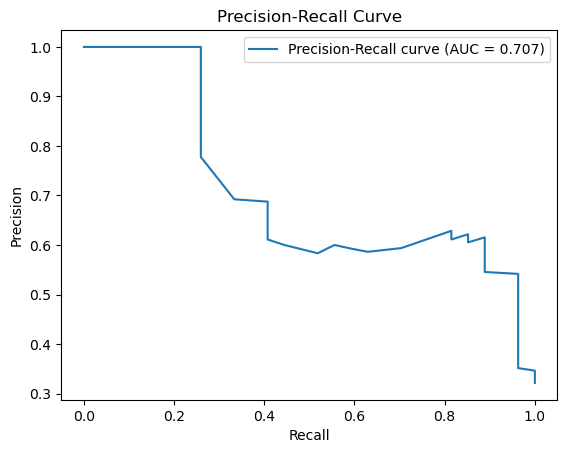

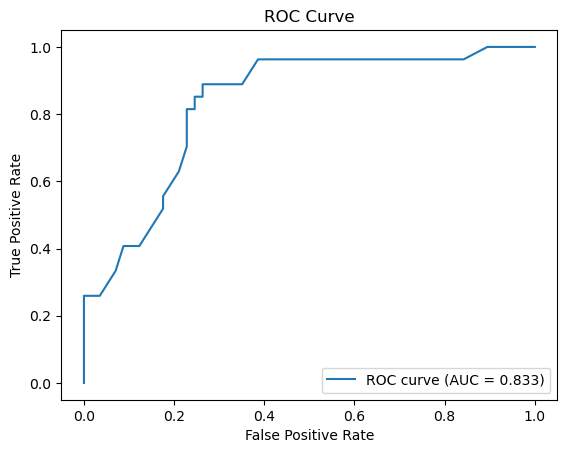

Test AUC-PR: 0.707


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

def build_pipeline():
    """Builds the machine learning pipeline with XGBClassifier."""
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)  # XGBoost classifier
    return Pipeline(steps=[('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__learning_rate': [0.1, 0.01],  # Learning rate
        'classifier__n_estimators': [50, 100, 200],  # Number of trees
        'classifier__max_depth': [3, 5, 8],  # Maximum tree depth
        'classifier__min_child_weight': [1, 5],  # Minimum child weight
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    for idx, score in enumerate(test_scores):
        print(f"Fold {idx + 1} score: {score:.3f}, SD: {test_score_std:.3f}")  # Print score and SD for each fold
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    # Print the best parameters for each fold
    for idx, result in enumerate(cv_results['estimator']):
        print(f"Fold {idx + 1} best parameters: {result.best_params_}")

    # Select the best model based on test scores
    best_fold_index = np.argmax(cv_results['test_score'])
    best_model = cv_results['estimator'][best_fold_index].best_estimator_
    best_params = cv_results['estimator'][best_fold_index].best_params_
    
    print(f"\nBest model parameters: {best_params}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    return y_test_pred, best_model

# Example usage (assuming X_train, y_train, X_test, y_test are already defined):
cv_results = perform_nested_cv(X_train, y_train)
y_test_pred, best_model = evaluate_model(cv_results, X_test, y_test)


# New confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_2847/4061163074.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


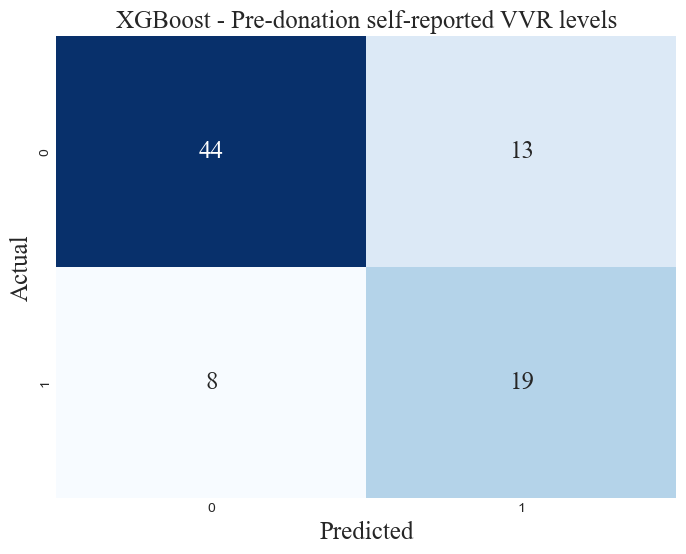

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('XGBoost - Pre-donation self-reported VVR levels', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()